In [1]:
import datetime

import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [ ]:
!pip install prophet

In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# GOOGLE_MY_DRIVE = "/content/drive/MyDrive/code/input/"
# INPUT_DIR = GOOGLE_MY_DRIVE

INPUT_DIR = "input/"

In [4]:
def plot_prediction(forecast, data_test):
    output = pd.merge(data_test, forecast , on='ds', how='left').set_index('ds')

    cond = (output.index >= test_start) & (output.index < test_end)
    actual = output[cond]['y'].apply(np.expm1) # 目的変数はlog(1+x)を適用してあるので元に戻す
    pred = output[cond]['yhat'].apply(np.expm1)

    mape = (np.abs(pred - actual) / actual * 100).mean()
    
    plt.title('Prophet prediction vs actual')
    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.ylabel('gas rate (sm3/hr)')
    plt.legend()
    plt.show()
    
    plt.title('Prophet residual') 
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [5]:
def learn_plot_prophet(df, train_start, test_start, test_end, add_feat=None):
    df_train = df[(df.index >= train_start) & (df.index < test_start)] #Prophetは内部パラメータ最適化が無いのでValidが不要
    df_test = df[(df.index >= test_start) & (df.index < test_end)]
    
    feats = ['ds', 'y']
    if add_feat != None:
        feats.extend(add_feat)
    
    data_train = df_train.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[feats].copy()
    data_test = df_test.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})[feats].copy()
    
    prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=False,
                  seasonality_mode='additive')
    
    if add_feat != None:
        for f in add_feat:
            prophet.add_regressor(f)
    
    prophet.fit(data_train)
    future = prophet.make_future_dataframe(periods=365, freq='D')
    
    
    if add_feat != None:
        feat_pred = ['ds']
        feat_pred.extend(add_feat)
        df_renamed = df.reset_index(drop=False).rename(columns={'date':'ds', 'gasrate':'y'})
        future = pd.merge(future, df_renamed[feat_pred], on='ds', how='left').dropna() 
    
    forecast = prophet.predict(future)
    fig = prophet.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
    prophet.plot_components(forecast)
    plt.show()
    
    return forecast, data_train, data_test

In [6]:
data = pd.read_csv(INPUT_DIR + "daily_production.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [7]:
data.tail()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
date,,,,,,,,,
2018-12-04,0.00000,0.0,0.0,27.7,4.6,24.0,2018,49,1
2018-12-05,98039.99869,97.9,22.0,19.0,30.9,2.0,2018,49,2
2018-12-06,108671.02850,98.8,24.0,16.7,31.0,0.0,2018,49,3
2018-12-07,0.00000,0.0,0.0,27.3,12.0,24.0,2018,49,4
2018-12-08,92931.04876,54.7,11.3,19.9,35.2,12.7,2018,49,5


In [8]:
data.describe()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
count,5.080000e+03,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000
mean,4.517001e+05,64.505906,18.132953,28.051555,32.831752,5.867047,2011.483465,26.507283,3.000000
std,5.511638e+05,44.109146,9.554588,21.576947,15.090307,9.554588,4.009995,14.978016,1.999705
min,0.000000e+00,0.000000,0.000000,0.000000,-20.000000,0.000000,2005.000000,1.000000,0.000000
25%,4.661764e+04,1.200000,14.075000,17.700000,28.375000,0.000000,2008.000000,14.000000,1.000000
50%,2.415290e+05,96.600000,24.000000,24.400000,37.800000,0.000000,2011.000000,26.500000,3.000000
75%,6.537928e+05,98.800000,24.000000,31.100000,43.800000,9.925000,2015.000000,39.000000,5.000000
max,2.737552e+06,100.000000,24.000000,190.300000,73.900000,24.000000,2018.000000,53.000000,6.000000


In [9]:
data['gasrate'] = (data['gasvol'] / data['hrsonline']).apply(np.log1p) # log(1+x)を適用
data['rate_shift_1d'] = data['gasrate'].shift(1).bfill() #前日の生産レート

In [10]:
data.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek,gasrate,rate_shift_1d
date,,,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1,11.220007,11.220007
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2,11.596875,11.220007
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3,NaN,11.596875
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4,NaN,11.215529
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5,NaN,11.215529


In [11]:
data.shape

(5080, 11)

In [12]:
train_start = datetime.datetime(2012, 1, 1)
test_start = datetime.datetime(2017, 9, 1)
test_end = datetime.datetime(2018, 9, 1)

In [13]:
cond = data['hrsonline'] > 20 #元のデータの75％は20時間以上Online
cond &= data['gasrate'] > 0 #Onlineでも生産量０は不正値とみなす。

df = data[cond].copy() # copyしないとメモリ上で値を共有するので片方をいじるともう片方も更新されてしまう。

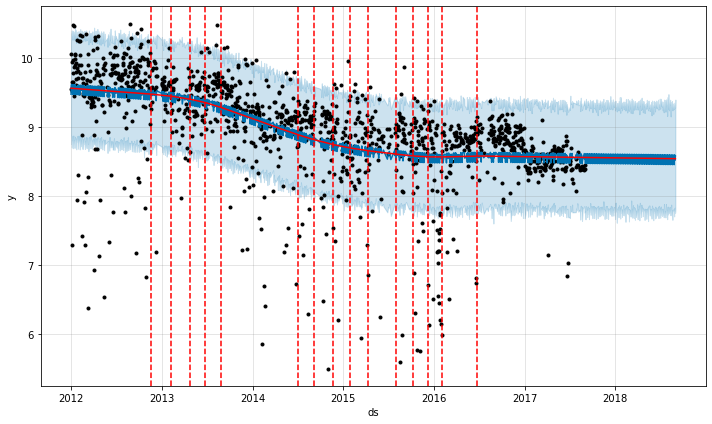

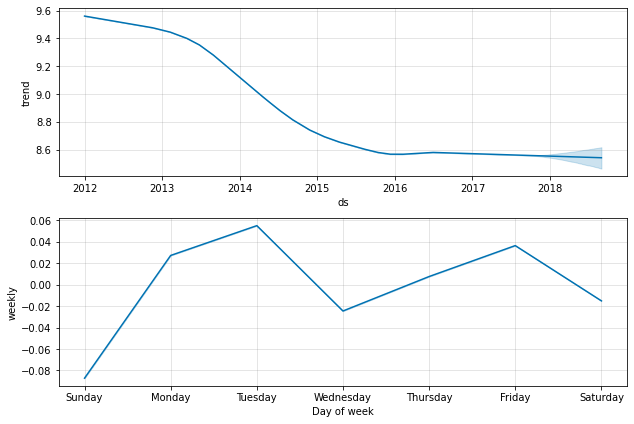

In [14]:
forecast, data_train, data_test = learn_plot_prophet(df, train_start, test_start, test_end)

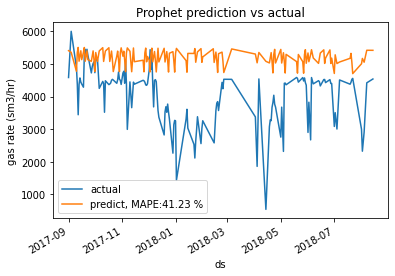

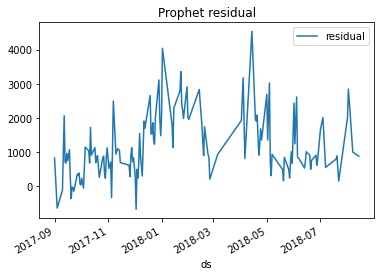

In [15]:
plot_prediction(forecast, data_test)

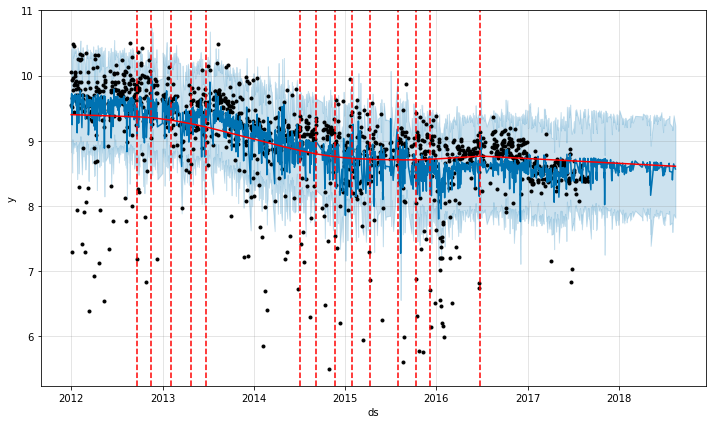

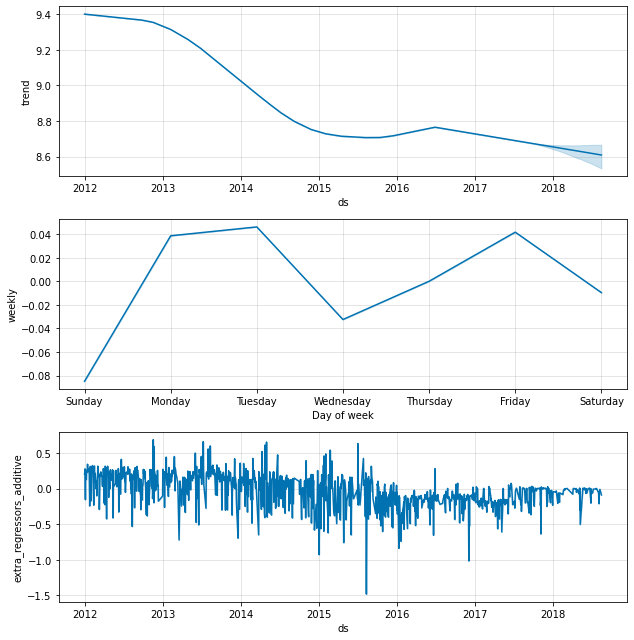

In [16]:
add_feats = ['choke', 'whp', 'hrsonline', 'rate_shift_1d']


forecast, data_train, data_test = learn_plot_prophet(df, train_start, test_start, test_end, add_feats)

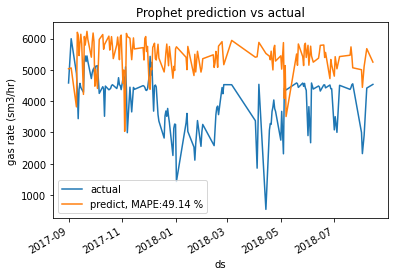

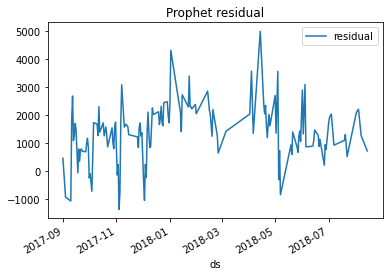

In [17]:
plot_prediction(forecast, data_test)